# The poster child

## Authors:
- **Adrian Price-Whelan** (Flatiron)
- **David W. Hogg** (NYU) (MPIA) (Flatiron)

## License:
Copyright 2020 the authors. **All rights reserved**.

## Notes:
- ...

In [4]:
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [15]:
name = '2M08160493+2858542'
visits = at.Table.read(f'{name}-allVisit.fits')
photom = at.Table.read(f'{name}-asassn.csv')

### RVs:

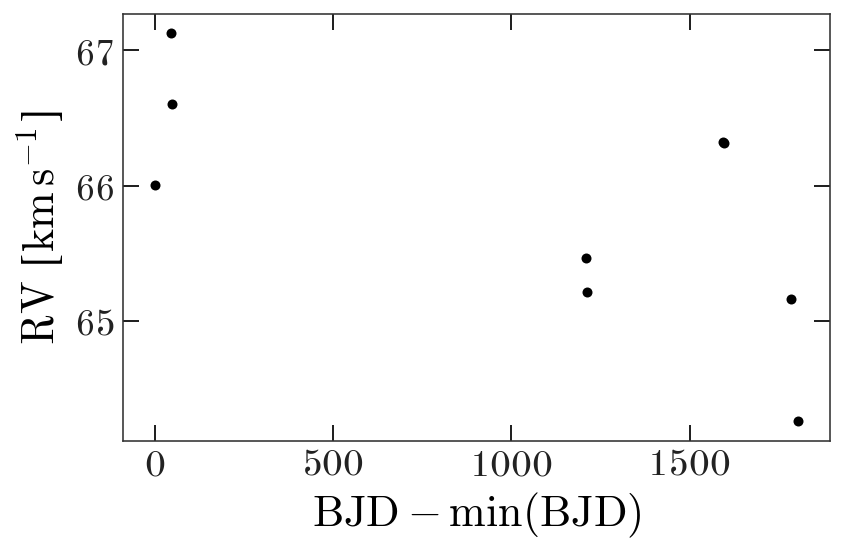

In [6]:
fig, ax = plt.subplots()
ax.errorbar(visits['JD'] - visits['JD'].min(), visits['VHELIO'], 
            yerr=visits['VRELERR'],
            marker='o', ls='none')
ax.set_xlabel(r'${\rm BJD} - {\rm min}({\rm BJD})$')
ax.set_ylabel(f'RV [{u.km/u.s:latex_inline}]')
fig.tight_layout()

### Photometry:

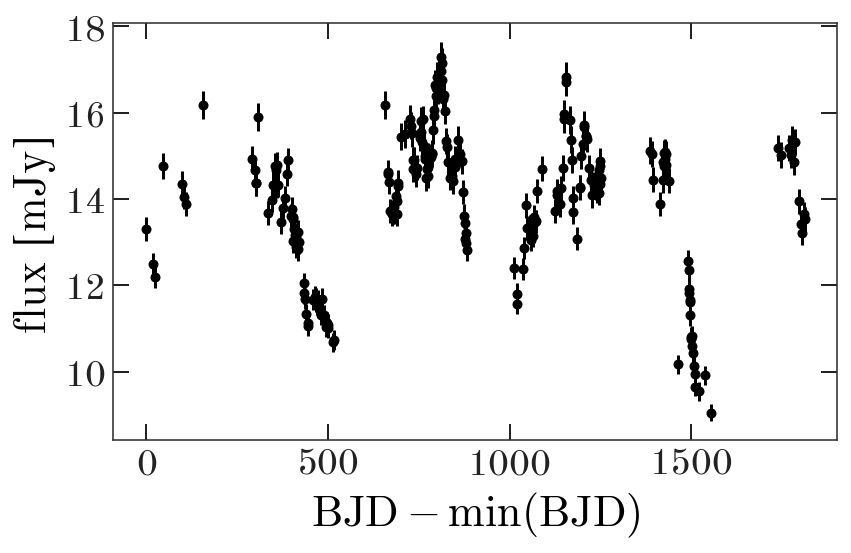

In [7]:
fig, ax = plt.subplots()
ax.errorbar(photom['hjd'] - photom['hjd'].min(), 
            photom['flux (mJy)'], 
            yerr=photom['flux err'],
            marker='o', ls='none')
ax.set_xlabel(r'${\rm BJD} - {\rm min}({\rm BJD})$')
ax.set_ylabel('flux [mJy]')
fig.tight_layout()

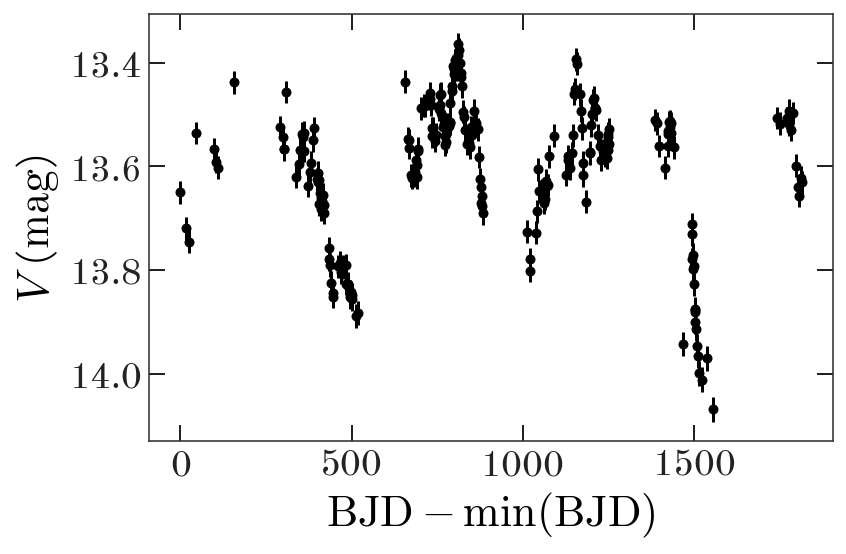

In [8]:
fig, ax = plt.subplots()
ax.errorbar(photom['hjd'] - photom['hjd'].min(), 
            photom['mag'], 
            yerr=photom['mag err'],
            marker='o', ls='none')
ax.set_xlabel(r'${\rm BJD} - {\rm min}({\rm BJD})$')
ax.set_ylabel(r'$V$ (mag)')
ax.invert_yaxis()
fig.tight_layout()

In [20]:
def fit_K_frequencies(f, df, L, Khalf, pts, pys, vts, vys):
    """
    fit a comb of frequencies to both the photometry and the RVs simultaneously
  
    ## inputs:
    - f: central frequency (cycles per day)
    - df: large frequency difference
    - L: lengthscale for converting flux derivatives into velocities
    - pts: photometry times in BJD (perhaps minus offset)
    - pys: photometry values; unspecific mag or flux
    - vts: radial velocity times in BJD (hopefully consistent with pts)
    - vys: radial velocity values
    - Khalf: use 2 * Khalf + 1 peaks; Khalf=0 is a pure sinusoid
  
    ## bugs:
    - CRITICAL BUG: Doesn't make use of inverse variances.
    - Doesn't account for the fact that photometry is in the log.
    """
    A = get_design_matrix(f, df, L, Khalf, pts, vts)
    return np.linalg.solve(np.dot(A.T, A), np.dot(A.T, np.append(pys, vys)))

def get_design_matrix(f, df, L, Khalf, pts, vts):
    """
    internal function for fit_K_frequencies()
    """
    vlist = [np.append(np.ones_like(pts), np.zeros_like(vts)),
             np.append(np.zeros_like(pts), np.ones_like(vts)), ]
    flist = np.arange(f - Khalf * df, f + Khalf * df + 0.5 * df, df)
    for tf in flist:
        omega = 2. * np.pi * tf
        vlist.append([np.append(np.cos(omega * pts),  omega * L * np.sin(omega * vts)),
                      np.append(np.sin(omega * pts), -omega * L * np.cos(omega * vts))])
    return np.vstack(vlist).T

In [176]:
def get_design_matrix_apw(f, df, L, Khalf, t_phot, t_rv):
    """
    Compute the design matrix without loops
    """
    n_phot = len(t_phot)
    n_rv = len(t_rv)

    M = np.zeros((n_phot + n_rv, 2*(Khalf + 1), 2))
    M[:n_phot, 0, 0] = 1.
    M[n_phot:, 0, 1] = 1.

    omegas = 2 * np.pi * np.arange(f - Khalf * df, 
                                   f + Khalf * df + 0.5 * df, 
                                   df)
    M[:n_phot, 1:, 0] = np.cos(omegas[None] * t_phot[:, None])
    M[:n_phot, 1:, 1] = np.sin(omegas[None] * t_phot[:, None])

    M[n_phot:, 1:, 0] =  omegas * L * np.sin(omegas[None] * t_rv[:, None])
    M[n_phot:, 1:, 1] = -omegas * L * np.cos(omegas[None] * t_rv[:, None])
    
    return M.reshape(M.shape[0], -1)

In [187]:
f = 0.0018 # inverse days
df = f / 5.
L = 300 # made up units of km, s, d, mJy
Khalf = 4
ref = np.round(np.median(photom['hjd'])).astype(int)
refmag = np.median(photom['mag'])
amps = fit_K_frequencies(f, df, L, Khalf,
               photom['hjd'] - ref, photom['flux (mJy)'],
               visits['JD'] - ref, visits['VHELIO'])
print(amps)

[ 25.69897677  59.95701705 -22.80352597  -2.10800283  19.19022377
   2.3542798  -13.71920318   0.11613619   8.54126712  -1.94944235
  -4.2900673    3.28543621   4.03559294  -5.39462584  -2.64049328
   4.74356708   1.64995039  -4.06109498  -0.21092136   1.73159778]


In [188]:
pltpt = np.arange(np.min(photom['hjd']) - ref - 0.25 / f,
                  np.max(photom['hjd']) - ref + 0.25 / f, 0.01 / f)
pltvt = np.arange(np.min(visits['JD']) - ref - 0.25 / f,
                  np.max(visits['JD']) - ref + 0.25 / f, 0.01 / f)
M = get_design_matrix(f, df, L, Khalf, pltpt, pltvt)
Mapw = get_design_matrix_apw(f, df, L, Khalf, pltpt, pltvt)
assert np.allclose(M, Mapw)
M.shape, Mapw.shape

((752, 20), (752, 20))

In [189]:
%timeit get_design_matrix(f, df, L, Khalf, pltpt, pltvt)
%timeit get_design_matrix_apw(f, df, L, Khalf, pltpt, pltvt)

341 µs ± 3.91 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
203 µs ± 6.23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Wow, all that numpy-fu for a factor of 1.5...oh well

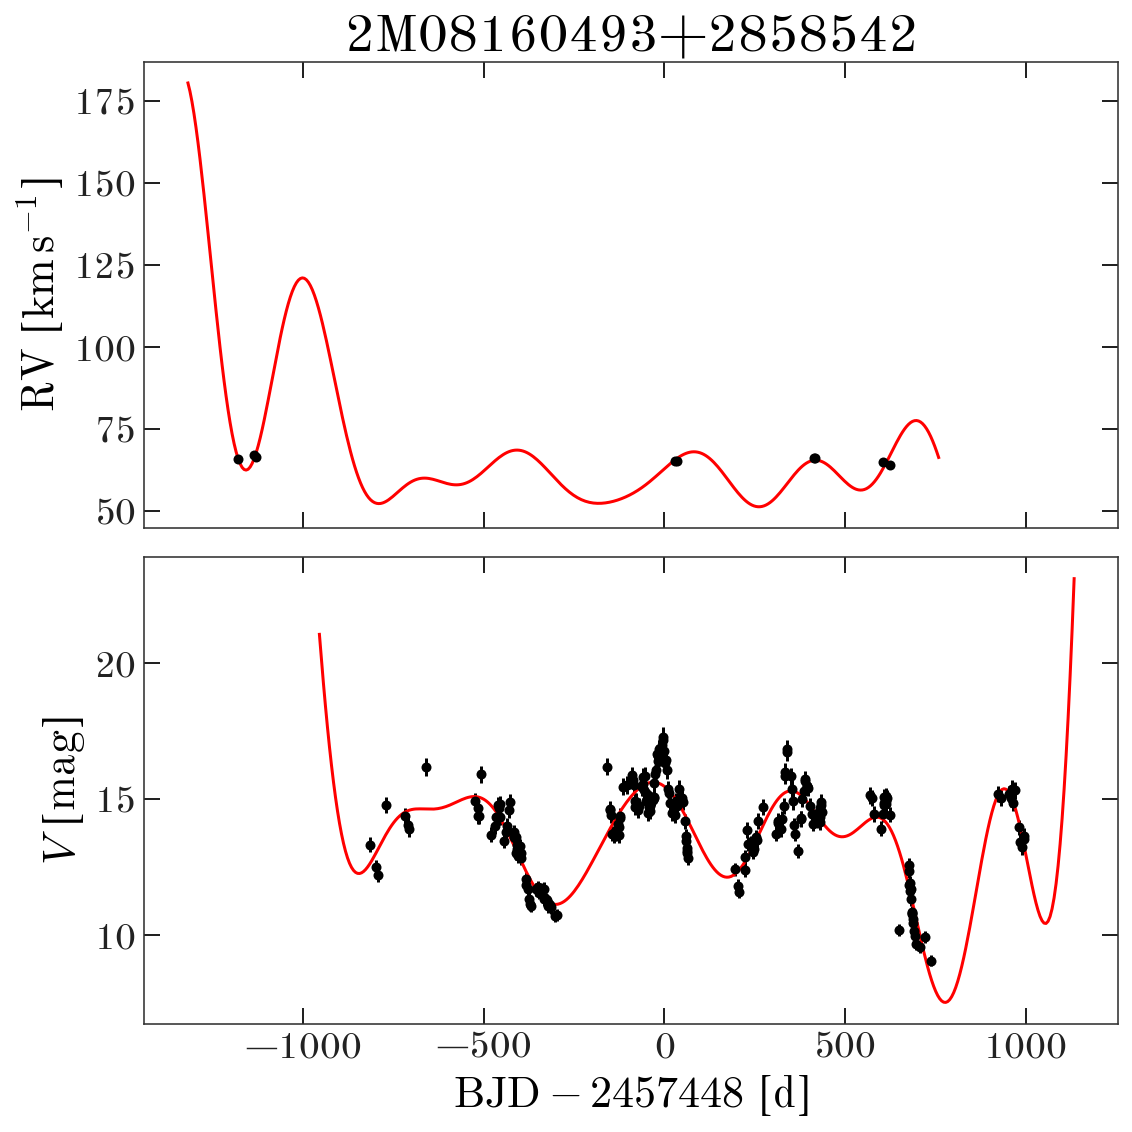

In [190]:
pltpt = np.arange(np.min(photom['hjd']) - ref - 0.25 / f,
                  np.max(photom['hjd']) - ref + 0.25 / f, 0.01 / f)
pltvt = np.arange(np.min(visits['JD']) - ref - 0.25 / f,
                  np.max(visits['JD']) - ref + 0.25 / f, 0.01 / f)

stuff = np.dot(get_design_matrix_apw(f, df, L, Khalf, pltpt, pltvt), amps)
pltpy = stuff[:len(pltpt)]
pltvy = stuff[-len(pltvt):]

fig, axes = plt.subplots(2, 1, figsize=(8, 8), 
                         sharex=True)

ax = axes[0]
ax.errorbar(visits['JD'] - ref, visits['VHELIO'], 
            yerr=visits['VRELERR'],
            marker='o', color='k', ls='none')
ax.set_ylabel(f'RV [{u.km/u.s:latex_inline}]')
ax.plot(pltvt, pltvy, "r-")
ax.set_title(name)

ax = axes[1]
ax.errorbar(photom['hjd'] - ref, 
            photom['flux (mJy)'], 
            yerr=photom['flux err'],
            marker='o', color='k', ls='none')
ax.set_xlabel(r'${\rm BJD} - ' + str(ref) + '$ [d]')
ax.set_ylabel('$V$ [mag]')
pltpt = np.arange(np.min(photom['hjd']) - ref - 0.25 / f,
                  np.max(photom['hjd']) - ref + 0.25 / f, 0.01 / f)
ax.plot(pltpt, pltpy, "r-")

fig.tight_layout()